In [1]:
# Last run with python 2.7 and tensorflow cpu version (that's why there are some warning here and there...)
# Previously was run with python 3.5 and tensorflow gpu verision

from __future__ import absolute_import, print_function, division

import far_ho as far
import tensorflow as tf
import far_ho.examples as far_ex

import os

/home/luca/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ordered-set package not found..


In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style('whitegrid')
%matplotlib inline

In [3]:
tf.reset_default_graph()
ss = tf.InteractiveSession()

In [4]:
x = tf.placeholder(tf.float32, shape=(None, 28**2), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

In [5]:
# load a small portion of mnist data
datasets = far_ex.mnist(folder=os.path.join(os.getcwd(), 'MNIST_DATA'), partitions=(.1, .1,))
datasets = far_ex.Datasets.from_list(datasets)

Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/MNIST_DATA/t10k-labels-idx1-ubyte.gz
datasets.redivide_data:, computed partitions numbers - [0, 7000, 14000, 70000] len all 70000 DONE


In [6]:
# build up a feddforward NN calssifier
import tensorflow.contrib.layers as tcl
with tf.variable_scope('model'):
    h1 = tcl.fully_connected(x, 300)
    out = tcl.fully_connected(h1, datasets.train.dim_target)
    print('Ground model weights (parameters)')
    [print(e) for e in tf.model_variables()];
with tf.variable_scope('inital_weight_model'):
    h1_hyp = tcl.fully_connected(x, 300,
                                 variables_collections=far.HYPERPARAMETERS_COLLECTIONS, 
                                trainable=False)
    out_hyp = tcl.fully_connected(h1_hyp, datasets.train.dim_target,
                                 variables_collections=far.HYPERPARAMETERS_COLLECTIONS,
                                 trainable=False)
    print('Initial model weights (hyperparameters)')
    [print(e) for e in far.utils.hyperparameters()];
#     far.utils.remove_from_collection(far.GraphKeys.MODEL_VARIABLES, *far.utils.hyperparameters())

Ground model weights (parameters)
<tf.Variable 'model/fully_connected/weights:0' shape=(784, 300) dtype=float32_ref>
<tf.Variable 'model/fully_connected/biases:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'model/fully_connected_1/weights:0' shape=(300, 10) dtype=float32_ref>
<tf.Variable 'model/fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>
Initial model weights (hyperparameters)
<tf.Variable 'inital_weight_model/fully_connected/weights:0' shape=(784, 300) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected/biases:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected_1/weights:0' shape=(300, 10) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>


In [7]:
# get an hyperparameter for weighting the examples for the inner objective loss (training error)
weights = far.get_hyperparameter('ex_weights', tf.zeros(datasets.train.num_examples))

In [8]:
# build loss and accuracy 
# inner objective (training error), weighted mean of cross entropy errors (with sigmoid to be sure is > 0)
with tf.name_scope('errors'):
    tr_loss = tf.reduce_mean(tf.sigmoid(weights)*tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))
    # outer objective (validation error) (not weighted)
    val_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(out, 1)), tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
# optimizers
# get an hyperparameter for the learning rate
lr = far.get_hyperparameter('lr', 0.01)
io_optim = far.GradientDescentOptimizer(lr)  # for training error minimization an optimizer from far_ho is needed
oo_optim = tf.train.AdamOptimizer()  # for outer objective optimizer all optimizers from tf are valid

In [10]:
print('hyperparameters to optimize')
[print(h) for h in far.hyperparameters()];

hyperparameters to optimize
<tf.Variable 'inital_weight_model/fully_connected/weights:0' shape=(784, 300) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected/biases:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected_1/weights:0' shape=(300, 10) dtype=float32_ref>
<tf.Variable 'inital_weight_model/fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'ex_weights:0' shape=(7000,) dtype=float32_ref>
<tf.Variable 'lr:0' shape=() dtype=float32_ref>


In [11]:
# build hyperparameter optimizer
farho = far.HyperOptimizer()
run = farho.minimize(val_loss, oo_optim, tr_loss, io_optim, 
                     init_dynamics_dict={v: h for v, h in zip(tf.model_variables(), far.utils.hyperparameters()[:4])})

In [12]:
print('Variables (or tensors) that will store the values of the hypergradients')
print(*far.hypergradients(), sep='\n')

Variables (or tensors) that will store the values of the hypergradients
Tensor("errors/Mean_1_1/gradients_3/errors/Mean_1_1/Vectorization_2/Reshape_1_grad/Reshape:0", shape=(300,), dtype=float32)
Tensor("errors/Mean_1_1/gradients_3/errors/Mean_1_1/Vectorization_2/Reshape_grad/Reshape:0", shape=(784, 300), dtype=float32)
<tf.Variable 'errors/Mean_1/ex_weights/hypergradient:0' shape=(7000,) dtype=float32_ref>
Tensor("errors/Mean_1_1/gradients_3/errors/Mean_1_1/Vectorization_2/Reshape_2_grad/Reshape:0", shape=(300, 10), dtype=float32)
Tensor("errors/Mean_1_1/gradients_3/errors/Mean_1_1/Vectorization_2/Reshape_3_grad/Reshape:0", shape=(10,), dtype=float32)
<tf.Variable 'errors/Mean_1/lr/hypergradient:0' shape=() dtype=float32_ref>


In [13]:
# run hyperparameter optimization 
T = 200 # performs 200 iteraitons of gradient descent on the training error (rise this values for better performances)
# get data suppliers (could also be stochastic for SGD)
tr_supplier = datasets.train.create_supplier(x, y)
val_supplier = datasets.validation.create_supplier(x, y)
tf.global_variables_initializer().run()

print('training accuracy', accuracy.eval(tr_supplier()))
print('validation accuracy', accuracy.eval(val_supplier()))
print('-'*50)

tr_accs, val_accs = [], []
for _ in range(20):
    run(T, inner_objective_feed_dicts=tr_supplier, outer_objective_feed_dicts=val_supplier)
    tr_accs.append(accuracy.eval(tr_supplier())), val_accs.append(accuracy.eval(val_supplier()))
    print('training accuracy', tr_accs[-1])
    print('validation accuracy', val_accs[-1])
    print('learning rate', lr.eval())
    print('norm of examples weight', tf.norm(weights).eval())
    print('-'*50)

training accuracy 0.10657143
validation accuracy 0.10414286
--------------------------------------------------
training accuracy 0.49142858
validation accuracy 0.463
learning rate 0.011
norm of examples weight 0.0786997
--------------------------------------------------
training accuracy 0.5412857
validation accuracy 0.5167143
learning rate 0.011991728
norm of examples weight 0.15491235
--------------------------------------------------
training accuracy 0.651
validation accuracy 0.62057143
learning rate 0.012977126
norm of examples weight 0.22778706
--------------------------------------------------
training accuracy 0.67071426
validation accuracy 0.64185715
learning rate 0.013939605
norm of examples weight 0.30000913
--------------------------------------------------
training accuracy 0.6807143
validation accuracy 0.65828574
learning rate 0.014869263
norm of examples weight 0.37109795
--------------------------------------------------
training accuracy 0.6892857
validation accuracy 0

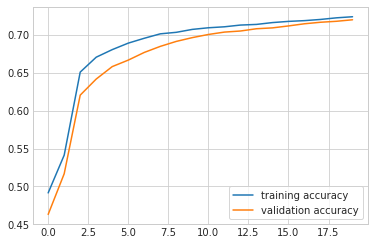

In [19]:
plt.plot(tr_accs, label='training accuracy')
plt.plot(val_accs, label='validation accuracy')
plt.legend(loc=0, frameon=True)
# plt.xlim(0, 19)